In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
import scienceplots
import scipy as sp
import pandas as pd

plt.style.use(['science','notebook','grid'])

In [2]:
m40 = 40e-3
m60 = 60e-3
m70 = 70e-3
m80 = 80e-3
m100 = 100e-3

r_p = 1.5e-2
r_m = 3e-2
r_g = 4.5e-2

In [3]:
quad = lambda x, a, b, c: a*x**2 + b*x + c
lin = lambda x, a, b: a*x + b

# Analyse vidéos

## Vidéo m40

In [4]:
video_path = "m40.mp4"
cap = cv2.VideoCapture(video_path)

In [5]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78801512879166


In [6]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [7]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78801512879166


In [8]:
def disp_f(num):
    plt.imshow(frames[num])

widgets.interact(disp_f, num=widgets.IntSlider(min=0, max=len(frames)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=1183), Output()), _dom_classes=('widget-intera…

<function __main__.disp_f(num)>

In [9]:
analyse = frames[363:1098]

In [10]:
def pos_track(x,y):
    image = analyse[0].copy()
    w, h = 50, 50
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)
    plt.imshow(image)

widgets.interact(pos_track, x=widgets.IntSlider(min=0, max=len(analyse[0]), step=1), y=widgets.IntSlider(min=0, max=len(analyse[0][0]), step=1))

interactive(children=(IntSlider(value=0, description='x', max=1080), IntSlider(value=0, description='y', max=1…

<function __main__.pos_track(x, y)>

In [11]:
tracker = cv2.TrackerCSRT_create()

track_frames = analyse.copy()

init_trac_f = track_frames[0]
roi = (357, 372, 50, 50)

tracker.init(init_trac_f, roi)

results = []
frame_tracked = []
for i in range(1, len(track_frames)):
    # Read the next frame
    frame = track_frames[i]

    # Update the tracker
    success, roi = tracker.update(frame)

    if success:
        # Draw a bounding box around the tracked object
        (x, y, w, h) = tuple(map(int, roi))
        results += [(x,y,w,h)]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        frame_tracked.append(frame)

In [12]:
def disp_t(num):
    plt.imshow(frame_tracked[num])

widgets.interact(disp_t, num=widgets.IntSlider(min=0, max=len(frame_tracked)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=733), Output()), _dom_classes=('widget-interac…

<function __main__.disp_t(num)>

In [13]:
good_results = results

In [14]:
center_of_rot = (705, 535, 50, 50)

In [15]:
def pos_from_case(case):
    x,y,w,h = case
    return (x + (x+w))/2, (y + (y+h))/2

In [16]:
pos_c = pos_from_case(center_of_rot)
pos_r = [pos_from_case(i) for i in good_results]

In [17]:
theta = []
cur_theta = 0

prev_dir = [pos_r[0][0]-pos_c[0], pos_r[0][1]-pos_c[1]]
for i in range(len(pos_r)):
    next_dir = [pos_r[i][0]-pos_c[0], pos_r[i][1]-pos_c[1]]
    cur_theta += (np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    if np.abs(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0])) > np.pi:
        cur_theta -= 2*np.pi*np.sign(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    theta.append(cur_theta)
    prev_dir = next_dir

print(theta)

[0.0, -0.08778354760691487, -0.17059950754332487, -0.25515083478660117, -0.3420496079415507, -0.42853843111429235, -0.5163805436501132, -0.5956304505778518, -0.6803220071901923, -0.7691987958307247, -0.8501164449283758, -0.9292067548102327, -1.0118297128772062, -1.0895543483739951, -1.1632919784526496, -1.2438661421891992, -1.3317588827435198, -1.4084541124224481, -1.4856950160464457, -1.5610214799230007, -1.6364023650343413, -1.7121523543398602, -1.7857973795759545, -1.8635683428033427, -1.944623534632176, -2.0264219860427, -2.1049255177639425, -2.1768933759590596, -2.255827277174643, -2.3302781542474524, -2.4039817330049225, -2.479053504956087, -2.555332654727632, -2.630548530655701, -2.701593830968021, -2.778090394992306, -2.849689351723903, -2.9254366487587924, -2.995742320062854, -3.0686134605708735, -3.1367161877010528, -3.213193391943208, -3.2821888381603923, -3.3539292526016613, -3.4180623064265405, -3.4927420018875073, -3.5649783223153935, -3.629213577915999, -3.70432907319945

In [18]:
time_1 = np.arange(len(theta))/frame_rate
popt_1, _ = sp.optimize.curve_fit(quad, time_1, theta)
popt_1

array([ 0.38865188, -3.67438253, -1.49138986])

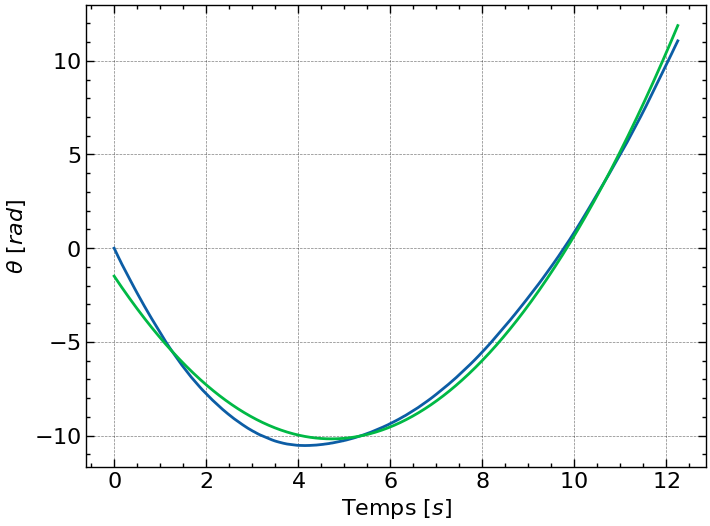

In [19]:
plt.plot(time_1, theta)
plt.plot(time_1, quad(time_1, *popt_1))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\theta$ $[rad]$")
plt.savefig("m40_t.png")

In [20]:
omega = []

for i in range(len(theta)-1):
    omega.append((theta[i+1]-theta[i])/(1/frame_rate))

In [21]:
time_2 = np.arange(len(omega))/frame_rate
popt_2, _ = sp.optimize.curve_fit(lin, time_2, omega)
popt_2

array([ 0.80432804, -4.02146438])

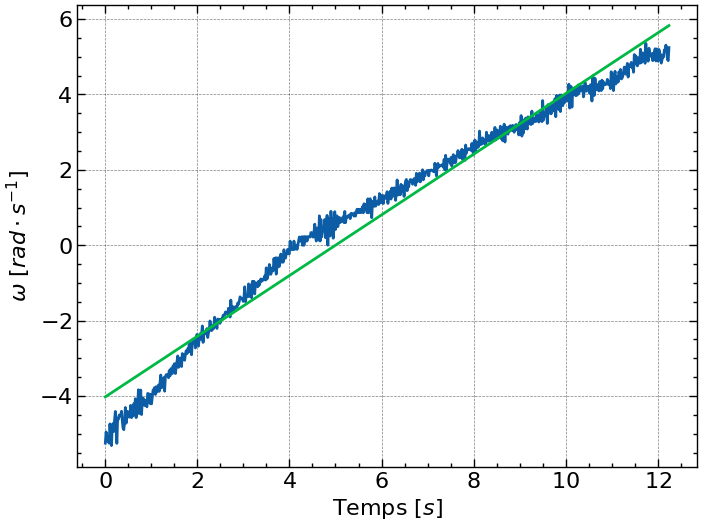

In [22]:
plt.plot(time_2, omega)
plt.plot(time_2, lin(time_2, *popt_2))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\omega$ $[rad \cdot s^{-1}]$")
plt.savefig("m40_o.png")

[-0.07261683  1.30070567]


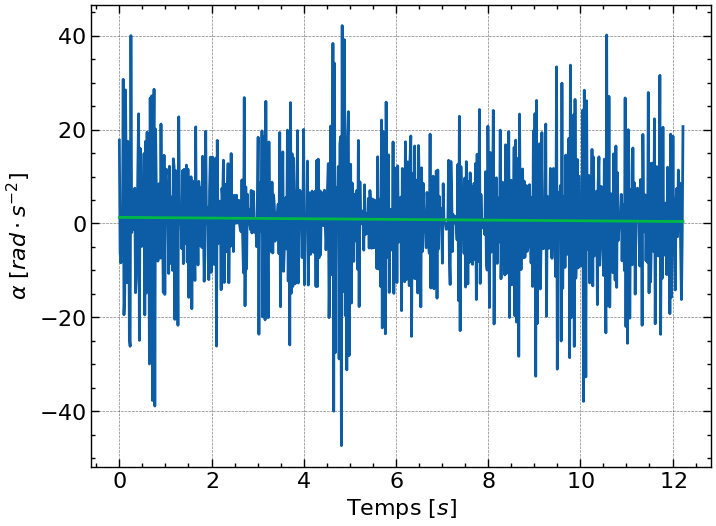

In [23]:
alpha = []

for i in range(len(omega)-1):
    alpha.append((omega[i+1]-omega[i])/(1/frame_rate))

time_3 = np.arange(len(alpha))/frame_rate
popt_3, _ = sp.optimize.curve_fit(lin, time_3, alpha)
print(popt_3)

plt.plot(np.arange(len(alpha))/frame_rate, alpha)
plt.plot(np.arange(len(alpha))/frame_rate, lin(time_3, *popt_3))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\alpha$ $[rad \cdot s^{-2}]$")
plt.savefig("m40_a.png")

In [24]:
acc_quad = popt_1[0]*2
acc_lin = popt_2[0]
print(acc_quad, acc_lin)
acc = (acc_quad + acc_lin)/2
Mom = 9.81 * m40 * r_m
I_m40 = Mom/acc
print(I_m40)

0.7773037662037253 0.8043280421534522
0.01488589182109007


## Vidéo m60

In [25]:
video_path = "m60.mp4"
cap = cv2.VideoCapture(video_path)

In [26]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78680582027616


In [27]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [28]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78680582027616


In [29]:
def disp_f(num):
    plt.imshow(frames[num])

widgets.interact(disp_f, num=widgets.IntSlider(min=0, max=len(frames)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=1008), Output()), _dom_classes=('widget-intera…

<function __main__.disp_f(num)>

In [30]:
analyse = frames[480:886]

In [31]:
def pos_track(x,y):
    image = analyse[0].copy()
    w, h = 50, 50
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)
    plt.imshow(image)

widgets.interact(pos_track, x=widgets.IntSlider(min=0, max=len(analyse[0]), step=1), y=widgets.IntSlider(min=0, max=len(analyse[0][0]), step=1))

interactive(children=(IntSlider(value=0, description='x', max=1080), IntSlider(value=0, description='y', max=1…

<function __main__.pos_track(x, y)>

In [32]:
tracker = cv2.TrackerCSRT_create()

track_frames = analyse.copy()

init_trac_f = track_frames[0]
roi = (331, 573, 50, 50)

tracker.init(init_trac_f, roi)

results = []
frame_tracked = []
for i in range(1, len(track_frames)):
    # Read the next frame
    frame = track_frames[i]

    # Update the tracker
    success, roi = tracker.update(frame)

    if success:
        # Draw a bounding box around the tracked object
        (x, y, w, h) = tuple(map(int, roi))
        results += [(x,y,w,h)]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        frame_tracked.append(frame)

In [33]:
def disp_t(num):
    plt.imshow(frame_tracked[num])

widgets.interact(disp_t, num=widgets.IntSlider(min=0, max=len(frame_tracked)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=404), Output()), _dom_classes=('widget-interac…

<function __main__.disp_t(num)>

In [34]:
good_results = results

In [35]:
center_of_rot = (705, 535, 50, 50)

In [36]:
def pos_from_case(case):
    x,y,w,h = case
    return (x + (x+w))/2, (y + (y+h))/2

In [37]:
pos_c = pos_from_case(center_of_rot)
pos_r = [pos_from_case(i) for i in good_results]

In [38]:
theta = []
cur_theta = 0

prev_dir = [pos_r[0][0]-pos_c[0], pos_r[0][1]-pos_c[1]]
for i in range(len(pos_r)):
    next_dir = [pos_r[i][0]-pos_c[0], pos_r[i][1]-pos_c[1]]
    cur_theta += (np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    if np.abs(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0])) > np.pi:
        cur_theta -= 2*np.pi*np.sign(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    theta.append(cur_theta)
    prev_dir = next_dir

print(theta)

[0.0, -0.046383276811095, -0.08874740571573225, -0.13015454387925285, -0.1689842042016183, -0.20942116835834357, -0.2499888461535571, -0.28640655690088135, -0.325777893533997, -0.365228466695386, -0.40142213321366826, -0.4361257163092036, -0.4816343216554446, -0.5141850004808606, -0.5466382305508484, -0.5805656365961904, -0.6163902699738131, -0.6521654293676904, -0.6861185272186199, -0.7160641998941495, -0.7480193006285791, -0.7782772257763795, -0.8091358123359877, -0.8360815550336964, -0.8640639541386701, -0.8895513269542765, -0.9169169629105376, -0.9437315393910448, -0.9704171568935482, -0.9958322101501587, -1.0177042457310117, -1.0419971862305242, -1.0662848688234565, -1.0862824828005717, -1.1038887648484175, -1.1214713557866443, -1.141499752778254, -1.1632870908165416, -1.1825279865082392, -1.2001600026499173, -1.2157661571794156, -1.2302345170409839, -1.2493546203854056, -1.2627825006997933, -1.2757993400617889, -1.2895988223581993, -1.2988987556016642, -1.3134218917500742, -1.326

In [39]:
time_1 = np.arange(len(theta))/frame_rate
popt_1, _ = sp.optimize.curve_fit(quad, time_1, theta)
popt_1

array([ 0.55067263, -1.06492991, -0.65186379])

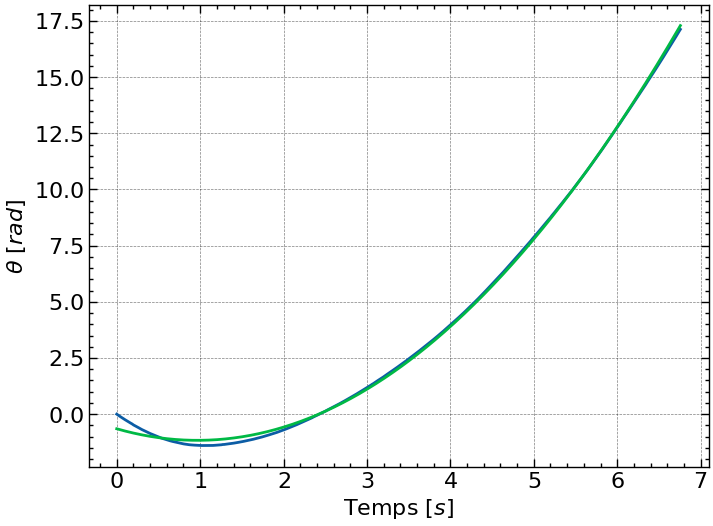

In [40]:
plt.plot(time_1, theta)
plt.plot(time_1, quad(time_1, *popt_1))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\theta$ $[rad]$")
plt.savefig("m60_t.png")

In [41]:
omega = []

for i in range(len(theta)-1):
    omega.append((theta[i+1]-theta[i])/(1/frame_rate))

In [42]:
time_2 = np.arange(len(omega))/frame_rate
popt_2, _ = sp.optimize.curve_fit(lin, time_2, omega)
popt_2

array([ 1.16505327, -1.39179803])

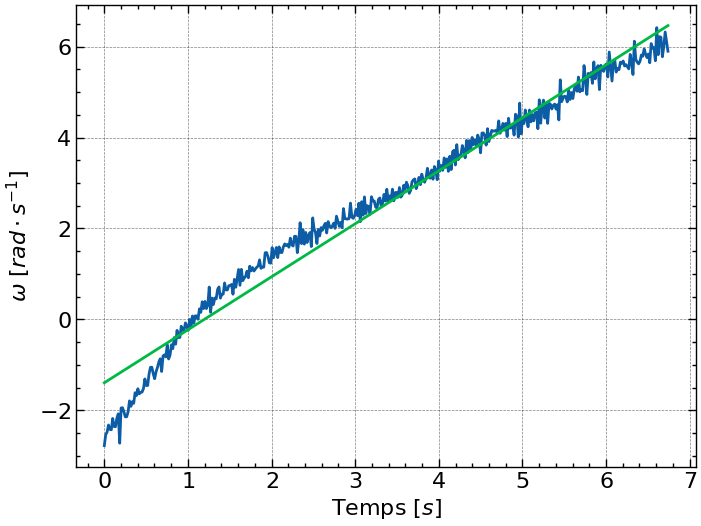

In [43]:
plt.plot(time_2, omega)
plt.plot(time_2, lin(time_2, *popt_2))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\omega$ $[rad \cdot s^{-1}]$")
plt.savefig("m60_o.png")

[-0.25749748  2.15202835]


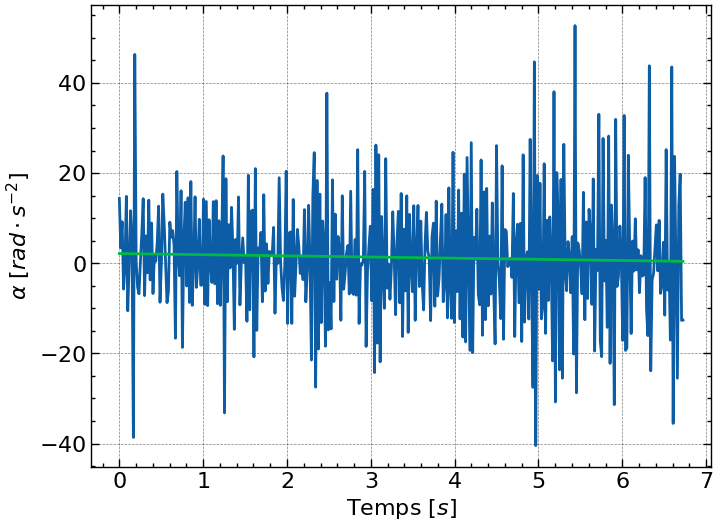

In [44]:
alpha = []

for i in range(len(omega)-1):
    alpha.append((omega[i+1]-omega[i])/(1/frame_rate))

time_3 = np.arange(len(alpha))/frame_rate
popt_3, _ = sp.optimize.curve_fit(lin, time_3, alpha)
print(popt_3)

plt.plot(np.arange(len(alpha))/frame_rate, alpha)
plt.plot(np.arange(len(alpha))/frame_rate, lin(time_3, *popt_3))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\alpha$ $[rad \cdot s^{-2}]$")
plt.savefig("m60_a.png")

In [45]:
acc_quad = popt_1[0]*2
acc_lin = popt_2[0]
print(acc_quad, acc_lin)
acc = (acc_quad + acc_lin)/2
Mom = 9.81 * m60 * r_m
I_m60 = Mom/acc
print(I_m60)

1.1013452537778434 1.1650532741707633
0.015582431582306796


## Vidéo p70

In [46]:
video_path = "p70.mp4"
cap = cv2.VideoCapture(video_path)

In [47]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  30.0


In [48]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [49]:
frame_rate = 120
print("Frame rate: ", frame_rate)

Frame rate:  120


In [50]:
def disp_f(num):
    plt.imshow(frames[num])

widgets.interact(disp_f, num=widgets.IntSlider(min=0, max=len(frames)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=2197), Output()), _dom_classes=('widget-intera…

<function __main__.disp_f(num)>

In [51]:
analyse = frames[532:1879]

In [52]:
def pos_track(x,y):
    image = analyse[0].copy()
    w, h = 50, 50
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)
    plt.imshow(image)

widgets.interact(pos_track, x=widgets.IntSlider(min=0, max=len(analyse[0]), step=1), y=widgets.IntSlider(min=0, max=len(analyse[0][0]), step=1))

interactive(children=(IntSlider(value=0, description='x', max=1080), IntSlider(value=0, description='y', max=1…

<function __main__.pos_track(x, y)>

In [53]:
tracker = cv2.TrackerCSRT_create()

track_frames = analyse.copy()

init_trac_f = track_frames[0]
roi = (1054, 666, 50, 50)

tracker.init(init_trac_f, roi)

results = []
frame_tracked = []
for i in range(1, len(track_frames)):
    # Read the next frame
    frame = track_frames[i]

    # Update the tracker
    success, roi = tracker.update(frame)

    if success:
        # Draw a bounding box around the tracked object
        (x, y, w, h) = tuple(map(int, roi))
        results += [(x,y,w,h)]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        frame_tracked.append(frame)

In [54]:
def disp_t(num):
    plt.imshow(frame_tracked[num])

widgets.interact(disp_t, num=widgets.IntSlider(min=0, max=len(frame_tracked)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=1345), Output()), _dom_classes=('widget-intera…

<function __main__.disp_t(num)>

In [55]:
good_results = results

In [56]:
center_of_rot = (722, 535, 50, 50)

In [57]:
def pos_from_case(case):
    x,y,w,h = case
    return (x + (x+w))/2, (y + (y+h))/2

In [58]:
pos_c = pos_from_case(center_of_rot)
pos_r = [pos_from_case(i) for i in good_results]

In [59]:
theta = []
cur_theta = 0

prev_dir = [pos_r[0][0]-pos_c[0], pos_r[0][1]-pos_c[1]]
for i in range(len(pos_r)):
    next_dir = [pos_r[i][0]-pos_c[0], pos_r[i][1]-pos_c[1]]
    cur_theta += (np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    if np.abs(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0])) > np.pi:
        cur_theta -= 2*np.pi*np.sign(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    theta.append(cur_theta)
    prev_dir = next_dir

print(theta)

[0.0, -0.030996209516437223, -0.041607678625293465, -0.08577825723190313, -0.11760688824400375, -0.14936612093480417, -0.15979701994223242, -0.20179540976564356, -0.23684876094692023, -0.26460644543076717, -0.29132120855139665, -0.32202142029908076, -0.35123193877102793, -0.36373966349080733, -0.40686576317582307, -0.43203768439805407, -0.4615489084633472, -0.49228053543770073, -0.5206559015693326, -0.5468670678674077, -0.5599578604963822, -0.6014281516399573, -0.6128881486869464, -0.6559984950971667, -0.6823357851508924, -0.710442936493695, -0.7377797241077169, -0.7695285762939448, -0.7962414902935852, -0.8068210177068809, -0.849237403983332, -0.8722322586937201, -0.9008694640870352, -0.9294279381150347, -0.9526168120626443, -0.9830442420968716, -0.9830442420968716, -1.0323708685132071, -1.0302119268330836, -1.0856358497400365, -1.1152188699827785, -1.1429397582678464, -1.1666876103959356, -1.1905127884702704, -1.2145300675992683, -1.2165079224726258, -1.2687367995227739, -1.296861614

In [60]:
time_1 = np.arange(len(theta))/frame_rate
popt_1, _ = sp.optimize.curve_fit(quad, time_1, theta)
popt_1

array([ 0.30196946, -2.03139018, -1.44260368])

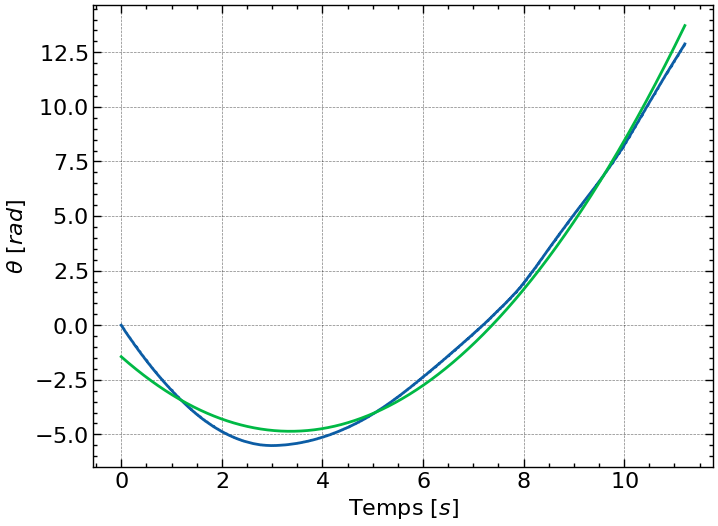

In [61]:
plt.plot(time_1, theta)
plt.plot(time_1, quad(time_1, *popt_1))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\theta$ $[rad]$")
plt.savefig("p70_t.png")

In [62]:
omega = []

for i in range(len(theta)-1):
    omega.append((theta[i+1]-theta[i])/(1/frame_rate))

In [63]:
time_2 = np.arange(len(omega))/frame_rate
popt_2, _ = sp.optimize.curve_fit(lin, time_2, omega)
popt_2

array([ 0.63267447, -2.39356945])

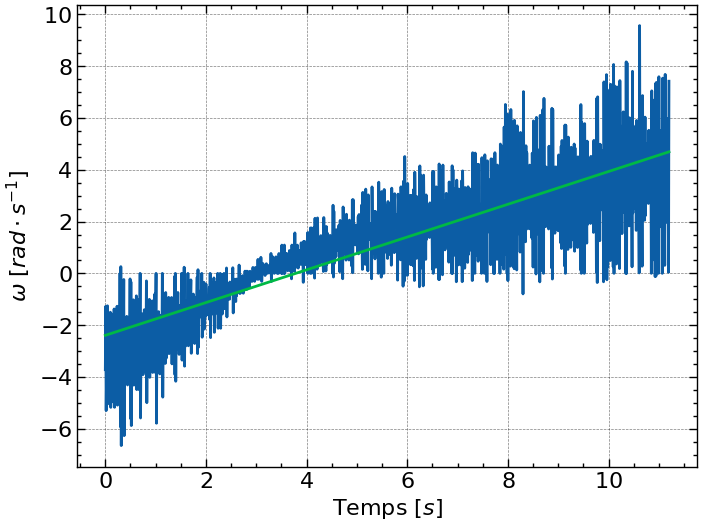

In [64]:
plt.plot(time_2, omega)
plt.plot(time_2, lin(time_2, *popt_2))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\omega$ $[rad \cdot s^{-1}]$")
plt.savefig("p70_o.png")

[0.06707486 0.61923022]


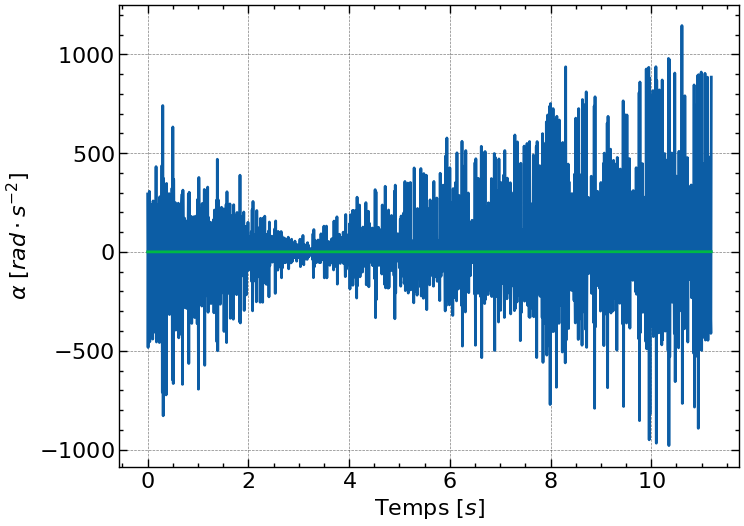

In [65]:
alpha = []

for i in range(len(omega)-1):
    alpha.append((omega[i+1]-omega[i])/(1/frame_rate))

time_3 = np.arange(len(alpha))/frame_rate
popt_3, _ = sp.optimize.curve_fit(lin, time_3, alpha)
print(popt_3)

plt.plot(np.arange(len(alpha))/frame_rate, alpha)
plt.plot(np.arange(len(alpha))/frame_rate, lin(time_3, *popt_3))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\alpha$ $[rad \cdot s^{-2}]$")
plt.savefig("p70_a.png")

In [66]:
acc_quad = popt_1[0]*2
acc_lin = popt_2[0]
print(acc_quad, acc_lin)
acc = (acc_quad + acc_lin)/2
Mom = 9.81 * m70 * r_p
I_p70 = Mom/acc
print(I_p70)

0.6039389114987118 0.6326744702267937
0.016659208370569663


## Vidéo m70

In [67]:
video_path = "m70.mp4"
cap = cv2.VideoCapture(video_path)

In [68]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  30.0


In [69]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [70]:
frame_rate = 120
print("Frame rate: ", frame_rate)

Frame rate:  120


In [71]:
def disp_f(num):
    plt.imshow(frames[num])

widgets.interact(disp_f, num=widgets.IntSlider(min=0, max=len(frames)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=1587), Output()), _dom_classes=('widget-intera…

<function __main__.disp_f(num)>

In [72]:
analyse = frames[755:1395]

In [73]:
def pos_track(x,y):
    image = analyse[0].copy()
    w, h = 50, 50
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)
    plt.imshow(image)

widgets.interact(pos_track, x=widgets.IntSlider(min=0, max=len(analyse[0]), step=1), y=widgets.IntSlider(min=0, max=len(analyse[0][0]), step=1))

interactive(children=(IntSlider(value=0, description='x', max=1080), IntSlider(value=0, description='y', max=1…

<function __main__.pos_track(x, y)>

In [74]:
tracker = cv2.TrackerCSRT_create()

track_frames = analyse.copy()

init_trac_f = track_frames[0]
roi = (1002, 310, 50, 50)

tracker.init(init_trac_f, roi)

results = []
frame_tracked = []
for i in range(1, len(track_frames)):
    # Read the next frame
    frame = track_frames[i]

    # Update the tracker
    success, roi = tracker.update(frame)

    if success:
        # Draw a bounding box around the tracked object
        (x, y, w, h) = tuple(map(int, roi))
        results += [(x,y,w,h)]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        frame_tracked.append(frame)

In [75]:
def disp_t(num):
    plt.imshow(frame_tracked[num])

widgets.interact(disp_t, num=widgets.IntSlider(min=0, max=len(frame_tracked)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=638), Output()), _dom_classes=('widget-interac…

<function __main__.disp_t(num)>

In [76]:
good_results = results

In [77]:
center_of_rot = (725, 535, 50, 50)

In [78]:
def pos_from_case(case):
    x,y,w,h = case
    return (x + (x+w))/2, (y + (y+h))/2

In [79]:
pos_c = pos_from_case(center_of_rot)
pos_r = [pos_from_case(i) for i in good_results]

In [80]:
theta = []
cur_theta = 0

prev_dir = [pos_r[0][0]-pos_c[0], pos_r[0][1]-pos_c[1]]
for i in range(len(pos_r)):
    next_dir = [pos_r[i][0]-pos_c[0], pos_r[i][1]-pos_c[1]]
    cur_theta += (np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    if np.abs(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0])) > np.pi:
        cur_theta -= 2*np.pi*np.sign(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    theta.append(cur_theta)
    prev_dir = next_dir

print(theta)

[0.0, -0.010025296500136505, -0.03769663497479936, -0.04759916896247118, -0.0753790716637942, -0.09122026243017767, -0.11305037484520375, -0.1307928407217125, -0.15066260033062517, -0.16463560309871628, -0.1725327890724142, -0.20250429057724917, -0.22018389985061337, -0.23535253400356493, -0.2530427887949934, -0.26780941363576927, -0.2873518033709801, -0.2959557672839802, -0.31773497135077733, -0.3288084265610671, -0.35345385388079387, -0.3693123401815608, -0.38495186184993657, -0.401359275938594, -0.4171437278535861, -0.416493732530983, -0.4480167899621301, -0.46280993367532086, -0.4817639454518263, -0.49700273724435284, -0.510415931738547, -0.5122383571943714, -0.5390355835607121, -0.5426437674753151, -0.5695707339327256, -0.585748074587356, -0.6001875333241435, -0.6136433293620032, -0.6263893695377152, -0.6270757001444605, -0.6543219817197063, -0.6543219817197063, -0.6811209270529175, -0.6945200649092911, -0.7074045150508463, -0.721928878503288, -0.7348291603874391, -0.7417146447923

In [81]:
time_1 = np.arange(len(theta))/frame_rate
popt_1, _ = sp.optimize.curve_fit(quad, time_1, theta)
popt_1

array([ 0.63896602, -1.54767844, -0.27137422])

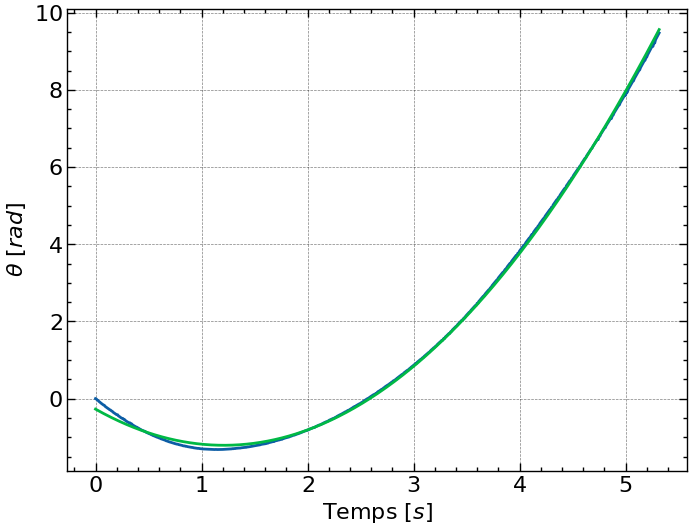

In [82]:
plt.plot(time_1, theta)
plt.plot(time_1, quad(time_1, *popt_1))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\theta$ $[rad]$")
plt.savefig("m70_t.png")

In [83]:
omega = []

for i in range(len(theta)-1):
    omega.append((theta[i+1]-theta[i])/(1/frame_rate))

In [84]:
time_2 = np.arange(len(omega))/frame_rate
popt_2, _ = sp.optimize.curve_fit(lin, time_2, omega)
popt_2

array([ 1.31694293, -1.71346566])

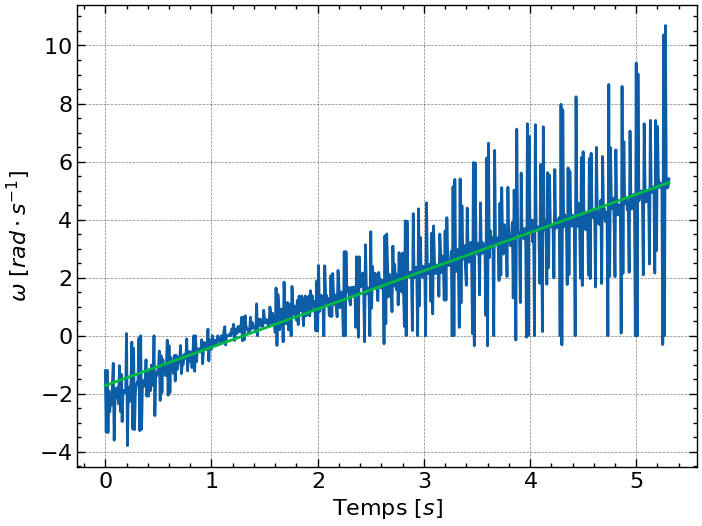

In [85]:
plt.plot(time_2, omega)
plt.plot(time_2, lin(time_2, *popt_2))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\omega$ $[rad \cdot s^{-1}]$")
plt.savefig("m70_o.png")

[0.13666336 0.88319805]


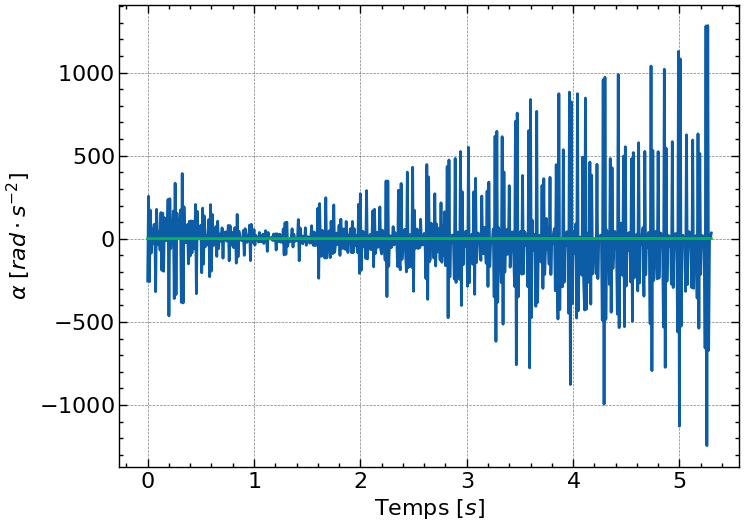

In [86]:
alpha = []

for i in range(len(omega)-1):
    alpha.append((omega[i+1]-omega[i])/(1/frame_rate))

time_3 = np.arange(len(alpha))/frame_rate
popt_3, _ = sp.optimize.curve_fit(lin, time_3, alpha)
print(popt_3)

plt.plot(np.arange(len(alpha))/frame_rate, alpha)
plt.plot(np.arange(len(alpha))/frame_rate, lin(time_3, *popt_3))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\alpha$ $[rad \cdot s^{-2}]$")
plt.savefig("m70_a.png")

In [87]:
acc_quad = popt_1[0]*2
acc_lin = popt_2[0]
print(acc_quad, acc_lin)
acc = (acc_quad + acc_lin)/2
Mom = 9.81 * m70 * r_m
I_m70 = Mom/acc
print(I_m70)

1.2779320473292384 1.3169429297856026
0.015878221634327522


## Vidéo g70

In [88]:
video_path = "g70.mp4"
cap = cv2.VideoCapture(video_path)

In [89]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  30.0


In [90]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [91]:
frame_rate = 120
print("Frame rate: ", frame_rate)

Frame rate:  120


In [92]:
def disp_f(num):
    plt.imshow(frames[num])

widgets.interact(disp_f, num=widgets.IntSlider(min=0, max=len(frames)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=2152), Output()), _dom_classes=('widget-intera…

<function __main__.disp_f(num)>

In [93]:
analyse = frames[903:2014]

In [94]:
def pos_track(x,y):
    image = analyse[0].copy()
    w, h = 50, 50
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)
    plt.imshow(image)

widgets.interact(pos_track, x=widgets.IntSlider(min=0, max=len(analyse[0]), step=1), y=widgets.IntSlider(min=0, max=len(analyse[0][0]), step=1))

interactive(children=(IntSlider(value=0, description='x', max=1080), IntSlider(value=0, description='y', max=1…

<function __main__.pos_track(x, y)>

In [95]:
tracker = cv2.TrackerCSRT_create()

track_frames = analyse.copy()

init_trac_f = track_frames[0]
roi = (1054, 635, 50, 50)

tracker.init(init_trac_f, roi)

results = []
frame_tracked = []
for i in range(1, len(track_frames)):
    # Read the next frame
    frame = track_frames[i]

    # Update the tracker
    success, roi = tracker.update(frame)

    if success:
        # Draw a bounding box around the tracked object
        (x, y, w, h) = tuple(map(int, roi))
        results += [(x,y,w,h)]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        frame_tracked.append(frame)

In [96]:
def disp_t(num):
    plt.imshow(frame_tracked[num])

widgets.interact(disp_t, num=widgets.IntSlider(min=0, max=len(frame_tracked)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=1109), Output()), _dom_classes=('widget-intera…

<function __main__.disp_t(num)>

In [97]:
good_results = results[698:895]

In [98]:
center_of_rot = (725, 520, 50, 50)

In [99]:
def pos_from_case(case):
    x,y,w,h = case
    return (x + (x+w))/2, (y + (y+h))/2

In [100]:
pos_c = pos_from_case(center_of_rot)
pos_r = [pos_from_case(i) for i in good_results]

In [101]:
theta = []
cur_theta = 0

prev_dir = [pos_r[0][0]-pos_c[0], pos_r[0][1]-pos_c[1]]
for i in range(len(pos_r)):
    next_dir = [pos_r[i][0]-pos_c[0], pos_r[i][1]-pos_c[1]]
    cur_theta += (np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    if np.abs(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0])) > np.pi:
        cur_theta -= 2*np.pi*np.sign(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    theta.append(cur_theta)
    prev_dir = next_dir

print(theta)

[0.0, 0.04380327424584418, 0.0698416768609268, 0.0992867396492505, 0.1275495712062367, 0.15595449000322364, 0.18201905017031114, 0.18201905017031114, 0.2389515692831007, 0.2389515692831007, 0.2927828500948424, 0.3211879679773309, 0.34958392252349124, 0.37242472153889855, 0.4007690803770129, 0.4123452161977905, 0.45257238524667115, 0.46425523408242664, 0.5045267572218198, 0.5292016199518361, 0.5549409253184747, 0.5792457025605646, 0.6020409778940783, 0.6165203331944827, 0.6535301930232286, 0.677958256811928, 0.7008074367585829, 0.7264356597051758, 0.7509199894769019, 0.7727436513269781, 0.7727436513269781, 0.81897851086037, 0.81897851086037, 0.8667841195764162, 0.8899530260598265, 0.9123015535090342, 0.9330765338721232, 0.9538260189455294, 0.9679485293908251, 1.0006258418614635, 1.0213182315819922, 1.0213182315819922, 1.0661535435207763, 1.0845792941324564, 1.1050027120437809, 1.127592081741108, 1.1480972337282869, 1.1480972337282869, 1.1893329524820495, 1.21019795998942, 1.228832605331

In [102]:
time_1 = np.arange(len(theta))/frame_rate
popt_1, _ = sp.optimize.curve_fit(quad, time_1, theta)
popt_1

array([-1.33778279e+00,  3.50021783e+00,  3.49643201e-03])

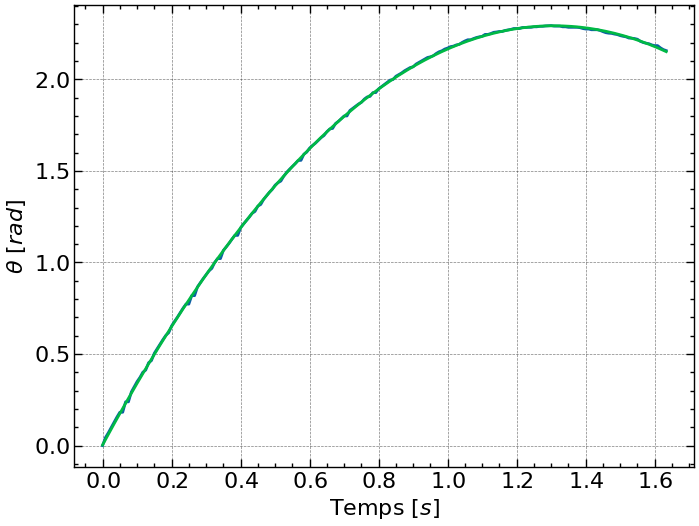

In [103]:
plt.plot(time_1, theta)
plt.plot(time_1, quad(time_1, *popt_1))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\theta$ $[rad]$")
plt.savefig("g70_t.png")

In [104]:
omega = []

for i in range(len(theta)-1):
    omega.append((theta[i+1]-theta[i])/(1/frame_rate))

In [105]:
time_2 = np.arange(len(omega))/frame_rate
popt_2, _ = sp.optimize.curve_fit(lin, time_2, omega)
popt_2

array([-2.67072506,  3.49072904])

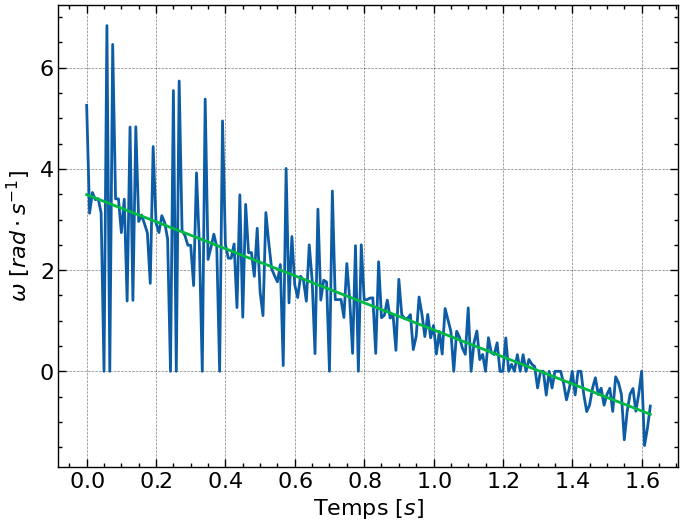

In [106]:
plt.plot(time_2, omega)
plt.plot(time_2, lin(time_2, *popt_2))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\omega$ $[rad \cdot s^{-1}]$")
plt.savefig("g70_o.png")

[ 4.40400655 -7.21711223]


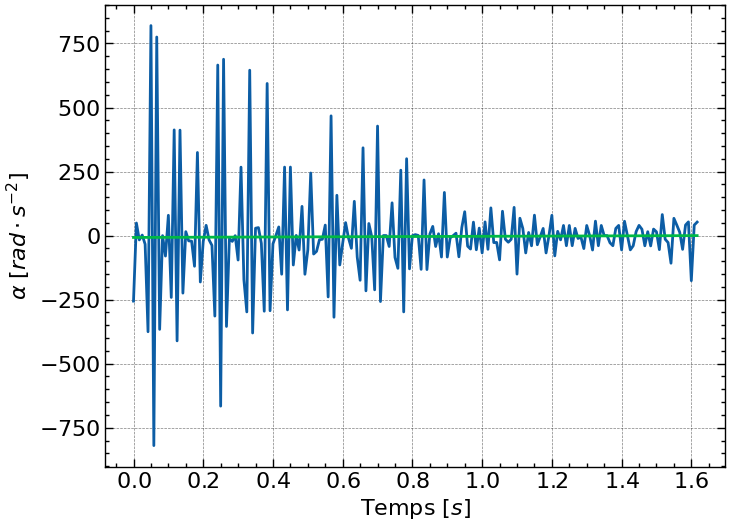

In [107]:
alpha = []

for i in range(len(omega)-1):
    alpha.append((omega[i+1]-omega[i])/(1/frame_rate))

time_3 = np.arange(len(alpha))/frame_rate
popt_3, _ = sp.optimize.curve_fit(lin, time_3, alpha)
print(popt_3)

plt.plot(np.arange(len(alpha))/frame_rate, alpha)
plt.plot(np.arange(len(alpha))/frame_rate, lin(time_3, *popt_3))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\alpha$ $[rad \cdot s^{-2}]$")
plt.savefig("g70_a.png")

In [108]:
acc_quad = popt_1[0]*2
acc_lin = popt_2[0]
print(acc_quad, acc_lin)
acc = (acc_quad + acc_lin)/2
Mom = 9.81 * m70 * r_g
I_g70 = Mom/acc
print(I_g70)

-2.675565570653598 -2.670725058482967
-0.011559977615728925


## Vidéo m80

In [109]:
video_path = "m80.mp4"
cap = cv2.VideoCapture(video_path)

In [110]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78746842677778


In [111]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [112]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78746842677778


In [113]:
def disp_f(num):
    plt.imshow(frames[num])

widgets.interact(disp_f, num=widgets.IntSlider(min=0, max=len(frames)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=1152), Output()), _dom_classes=('widget-intera…

<function __main__.disp_f(num)>

In [114]:
analyse = frames[678:957]

In [115]:
def pos_track(x,y):
    image = analyse[0].copy()
    w, h = 50, 50
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)
    plt.imshow(image)

widgets.interact(pos_track, x=widgets.IntSlider(min=0, max=len(analyse[0]), step=1), y=widgets.IntSlider(min=0, max=len(analyse[0][0]), step=1))

interactive(children=(IntSlider(value=0, description='x', max=1080), IntSlider(value=0, description='y', max=1…

<function __main__.pos_track(x, y)>

In [116]:
tracker = cv2.TrackerCSRT_create()

track_frames = analyse.copy()

init_trac_f = track_frames[0]
roi = (401, 294, 50, 50)

tracker.init(init_trac_f, roi)

results = []
frame_tracked = []
for i in range(1, len(track_frames)):
    # Read the next frame
    frame = track_frames[i]

    # Update the tracker
    success, roi = tracker.update(frame)

    if success:
        # Draw a bounding box around the tracked object
        (x, y, w, h) = tuple(map(int, roi))
        results += [(x,y,w,h)]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        frame_tracked.append(frame)

In [117]:
def disp_t(num):
    plt.imshow(frame_tracked[num])

widgets.interact(disp_t, num=widgets.IntSlider(min=0, max=len(frame_tracked)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=277), Output()), _dom_classes=('widget-interac…

<function __main__.disp_t(num)>

In [118]:
good_results = results

In [119]:
center_of_rot = (705, 535, 50, 50)

In [120]:
def pos_from_case(case):
    x,y,w,h = case
    return (x + (x+w))/2, (y + (y+h))/2

In [121]:
pos_c = pos_from_case(center_of_rot)
pos_r = [pos_from_case(i) for i in good_results]

In [122]:
theta = []
cur_theta = 0

prev_dir = [pos_r[0][0]-pos_c[0], pos_r[0][1]-pos_c[1]]
for i in range(len(pos_r)):
    next_dir = [pos_r[i][0]-pos_c[0], pos_r[i][1]-pos_c[1]]
    cur_theta += (np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    if np.abs(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0])) > np.pi:
        cur_theta -= 2*np.pi*np.sign(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    theta.append(cur_theta)
    prev_dir = next_dir

print(theta)

[0.0, -0.03351529685154597, -0.061766029641606934, -0.09542503022461757, -0.12072140963968891, -0.14912421176569035, -0.1786368392925608, -0.2063468739996459, -0.23483413978920975, -0.26032114218349056, -0.2840963777029568, -0.3086339577490933, -0.3340273255975359, -0.3569915570857578, -0.3781179566327788, -0.40132102303162354, -0.42113884137910107, -0.4435170622073539, -0.4644126832071942, -0.48426890882233753, -0.5029833012852252, -0.5221252777668921, -0.5393300065382354, -0.5548421501731746, -0.5729908121751492, -0.5847528264468131, -0.5992000290910728, -0.6173401912450336, -0.6303070371103634, -0.6432870562466526, -0.6536892214798602, -0.6692859648378877, -0.6784285556413399, -0.6900577068257081, -0.6978368038801674, -0.7095828767580437, -0.7187494976922677, -0.723929661199171, -0.7345226715542981, -0.73827896371031, -0.7446021725336851, -0.7503308138486795, -0.7526248767176975, -0.7595392442860627, -0.7606749101627779, -0.7647098921777196, -0.765837333220333, -0.7698738123653417, 

In [123]:
time_1 = np.arange(len(theta))/frame_rate
popt_1, _ = sp.optimize.curve_fit(quad, time_1, theta)
popt_1

array([ 0.70658563, -1.19618068, -0.1905181 ])

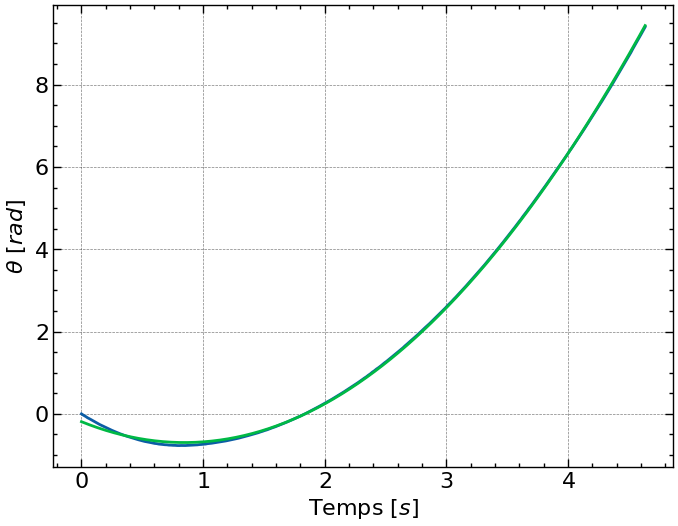

In [124]:
plt.plot(time_1, theta)
plt.plot(time_1, quad(time_1, *popt_1))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\theta$ $[rad]$")
plt.savefig("m80_t.png")

In [125]:
omega = []

for i in range(len(theta)-1):
    omega.append((theta[i+1]-theta[i])/(1/frame_rate))

In [126]:
time_2 = np.arange(len(omega))/frame_rate
popt_2, _ = sp.optimize.curve_fit(lin, time_2, omega)
popt_2

array([ 1.45686417, -1.33383892])

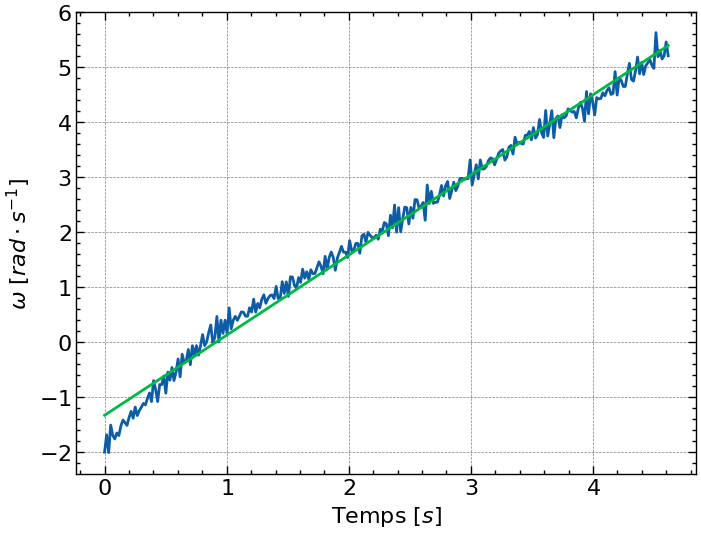

In [127]:
plt.plot(time_2, omega)
plt.plot(time_2, lin(time_2, *popt_2))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\omega$ $[rad \cdot s^{-1}]$")
plt.savefig("m80_o.png")

[-0.24202158  2.11818713]


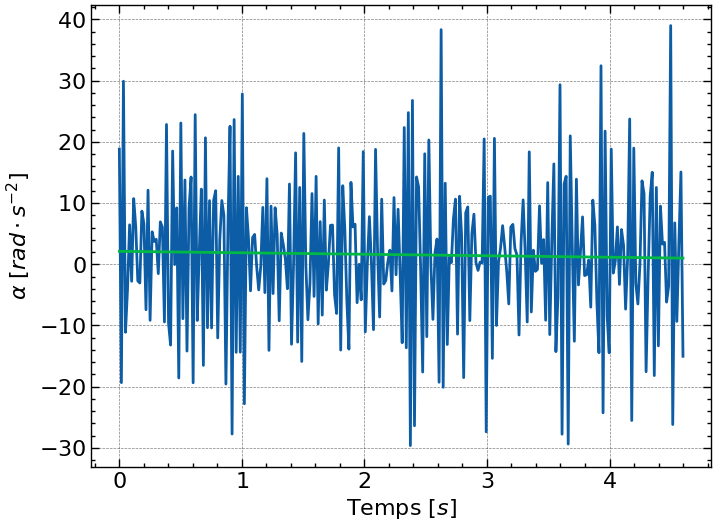

In [128]:
alpha = []

for i in range(len(omega)-1):
    alpha.append((omega[i+1]-omega[i])/(1/frame_rate))

time_3 = np.arange(len(alpha))/frame_rate
popt_3, _ = sp.optimize.curve_fit(lin, time_3, alpha)
print(popt_3)

plt.plot(np.arange(len(alpha))/frame_rate, alpha)
plt.plot(np.arange(len(alpha))/frame_rate, lin(time_3, *popt_3))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\alpha$ $[rad \cdot s^{-2}]$")
plt.savefig("m80_a.png")

In [129]:
acc_quad = popt_1[0]*2
acc_lin = popt_2[0]
print(acc_quad, acc_lin)
acc = (acc_quad + acc_lin)/2
Mom = 9.81 * m80 * r_m
I_m80 = Mom/acc
print(I_m80)

1.4131712550841267 1.4568641739241976
0.016406766106113954


## Vidéo m100

In [130]:
video_path = "m100.mp4"
cap = cv2.VideoCapture(video_path)

In [131]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78130509097191


In [132]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [133]:
frame_rate = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate: ", frame_rate)

Frame rate:  59.78130509097191


In [134]:
def disp_f(num):
    plt.imshow(frames[num])

widgets.interact(disp_f, num=widgets.IntSlider(min=0, max=len(frames)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=791), Output()), _dom_classes=('widget-interac…

<function __main__.disp_f(num)>

In [135]:
analyse = frames[356:662]

In [136]:
def pos_track(x,y):
    image = analyse[0].copy()
    w, h = 50, 50
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)
    plt.imshow(image)

widgets.interact(pos_track, x=widgets.IntSlider(min=0, max=len(analyse[0]), step=1), y=widgets.IntSlider(min=0, max=len(analyse[0][0]), step=1))

interactive(children=(IntSlider(value=0, description='x', max=1080), IntSlider(value=0, description='y', max=1…

<function __main__.pos_track(x, y)>

In [137]:
tracker = cv2.TrackerCSRT_create()

track_frames = analyse.copy()

init_trac_f = track_frames[0]
roi = (418, 279, 50, 50)

tracker.init(init_trac_f, roi)

results = []
frame_tracked = []
for i in range(1, len(track_frames)):
    # Read the next frame
    frame = track_frames[i]

    # Update the tracker
    success, roi = tracker.update(frame)

    if success:
        # Draw a bounding box around the tracked object
        (x, y, w, h) = tuple(map(int, roi))
        results += [(x,y,w,h)]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 4)
        frame_tracked.append(frame)

In [138]:
def disp_t(num):
    plt.imshow(frame_tracked[num])

widgets.interact(disp_t, num=widgets.IntSlider(min=0, max=len(frame_tracked)-1, step=1))

interactive(children=(IntSlider(value=0, description='num', max=304), Output()), _dom_classes=('widget-interac…

<function __main__.disp_t(num)>

In [139]:
good_results = results[0:277]

In [140]:
center_of_rot = (705, 535, 50, 50)

In [141]:
def pos_from_case(case):
    x,y,w,h = case
    return (x + (x+w))/2, (y + (y+h))/2

In [142]:
pos_c = pos_from_case(center_of_rot)
pos_r = [pos_from_case(i) for i in good_results]

In [143]:
theta = []
cur_theta = 0

prev_dir = [pos_r[0][0]-pos_c[0], pos_r[0][1]-pos_c[1]]
for i in range(len(pos_r)):
    next_dir = [pos_r[i][0]-pos_c[0], pos_r[i][1]-pos_c[1]]
    cur_theta += (np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    if np.abs(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0])) > np.pi:
        cur_theta -= 2*np.pi*np.sign(np.arctan2(next_dir[1], next_dir[0]) - np.arctan2(prev_dir[1], prev_dir[0]))
    theta.append(cur_theta)
    prev_dir = next_dir

print(theta)

[0.0, -0.07118707274296376, -0.14414895625611068, -0.21949067471002426, -0.28641815152193795, -0.35986876501066956, -0.43131650120932497, -0.5034937685398377, -0.575541813344806, -0.6408766570481141, -0.7060875973123704, -0.7740333815239029, -0.8450845470731321, -0.9069616148433948, -0.9696355473074374, -1.0338017887510467, -1.1007296210767783, -1.1623734616490187, -1.2212177431155604, -1.2822995085797584, -1.3402878613562117, -1.4028677249995365, -1.4615731774941763, -1.514962208937496, -1.5664169306634075, -1.625407819080091, -1.6821973226303437, -1.7367742529236518, -1.7877313730111988, -1.8411654063092386, -1.889558629680698, -1.9412060628221415, -1.9921242364339742, -2.0398838107291057, -2.0896915650714023, -2.1363644899388117, -2.180564378730214, -2.227277586070473, -2.272633371539565, -2.3153153762374794, -2.3621337704532603, -2.4042180450215325, -2.444361315428644, -2.4864381972737144, -2.529011990199563, -2.5673941131072477, -2.607444232533383, -2.644421986677937, -2.682574292

In [144]:
time_1 = np.arange(len(theta))/frame_rate
popt_1, _ = sp.optimize.curve_fit(quad, time_1, theta)
popt_1

array([ 1.03777155, -3.58824855, -0.3479185 ])

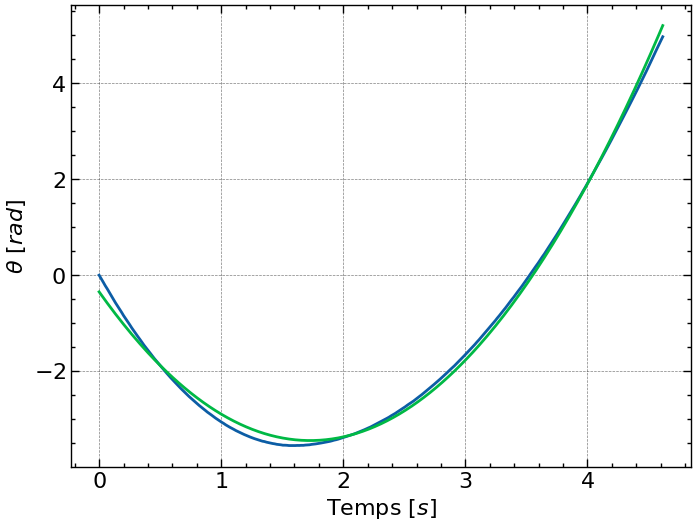

In [145]:
plt.plot(time_1, theta)
plt.plot(time_1, quad(time_1, *popt_1))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\theta$ $[rad]$")
plt.savefig("m100_t.png")

In [146]:
omega = []

for i in range(len(theta)-1):
    omega.append((theta[i+1]-theta[i])/(1/frame_rate))

In [147]:
time_2 = np.arange(len(omega))/frame_rate
popt_2, _ = sp.optimize.curve_fit(lin, time_2, omega)
popt_2

array([ 2.10807802, -3.7714946 ])

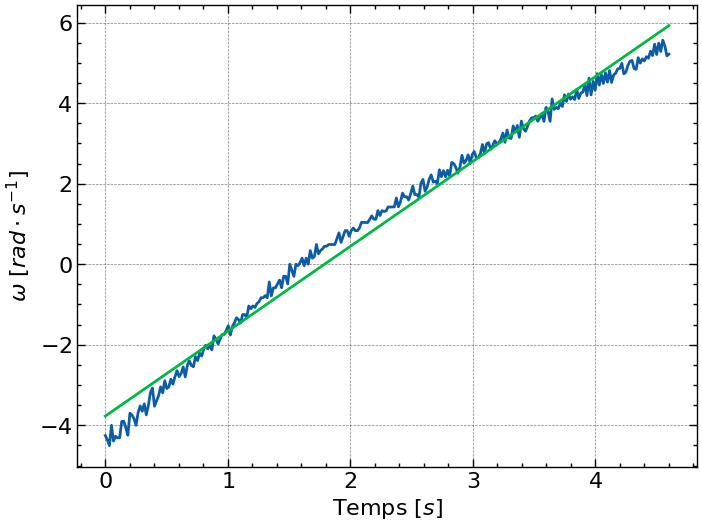

In [148]:
plt.plot(time_2, omega)
plt.plot(time_2, lin(time_2, *popt_2))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\omega$ $[rad \cdot s^{-1}]$")
plt.savefig("m100_o.png")

[-0.33995123  2.83795285]


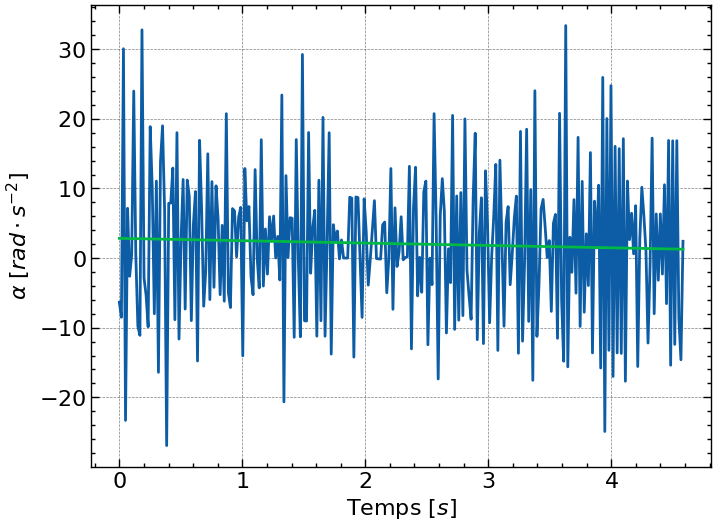

In [149]:
alpha = []

for i in range(len(omega)-1):
    alpha.append((omega[i+1]-omega[i])/(1/frame_rate))

time_3 = np.arange(len(alpha))/frame_rate
popt_3, _ = sp.optimize.curve_fit(lin, time_3, alpha)
print(popt_3)

plt.plot(np.arange(len(alpha))/frame_rate, alpha)
plt.plot(np.arange(len(alpha))/frame_rate, lin(time_3, *popt_3))
plt.xlabel(r"Temps $[s]$")
plt.ylabel(r"$\alpha$ $[rad \cdot s^{-2}]$")
plt.savefig("m100_a.png")

In [150]:
acc_quad = popt_1[0]*2
acc_lin = popt_2[0]
print(acc_quad, acc_lin)
acc = (acc_quad + acc_lin)/2
Mom = 9.81 * m100 * r_m
I_m100 = Mom/acc
print(I_m100)

2.0755430982955625 2.1080780173316844
0.01406915166866758


# Analyse résultats

In [151]:
tabular = pd.DataFrame({
              "Mass": [40e-3, 60e-3, 70e-3, 70e-3, 70e-3, 80e-3, 100e-3], 
              "Radius": [r_m, r_m, r_p, r_m, r_g, r_m, r_m],
              "Moment of Inertia": [I_m40, I_m60, I_p70, I_m70, np.abs(I_g70), I_m80, I_m100]
              })
tabular["Angular Acceleration"] = tabular["Mass"]*9.81*tabular["Radius"]/tabular["Moment of Inertia"]

tabular

,Mass,Radius,Moment of Inertia,Angular Acceleration
0,0.04,0.030,0.014886,0.790816
1,0.06,0.030,0.015582,1.133199
2,0.07,0.015,0.016659,0.618307
3,0.07,0.030,0.015878,1.297437
4,0.07,0.045,0.011560,2.673145
5,0.08,0.030,0.016407,1.435018
6,0.10,0.030,0.014069,2.091811


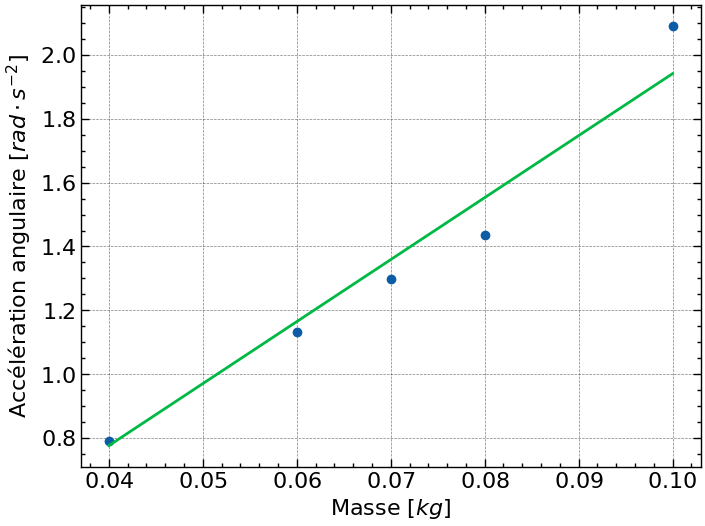

In [152]:
# Plot a graph of the acceleration against the mass for all the measure with radius r_m
plt.plot(tabular["Mass"][tabular["Radius"] == r_m], tabular["Angular Acceleration"][tabular["Radius"] == r_m], "o")
popt_fr, _ = sp.optimize.curve_fit(prop:=lambda x,a: a*x, tabular["Mass"][tabular["Radius"] == r_m], tabular["Angular Acceleration"][tabular["Radius"] == r_m])
plt.plot(np.array([40e-3, 100e-3]), prop(np.array([40e-3, 100e-3]), *popt_fr))
plt.xlabel(r"Masse $[kg]$")
plt.ylabel(r"Accélération angulaire $[rad \cdot s^{-2}]$")
plt.savefig("prop_masse.png")

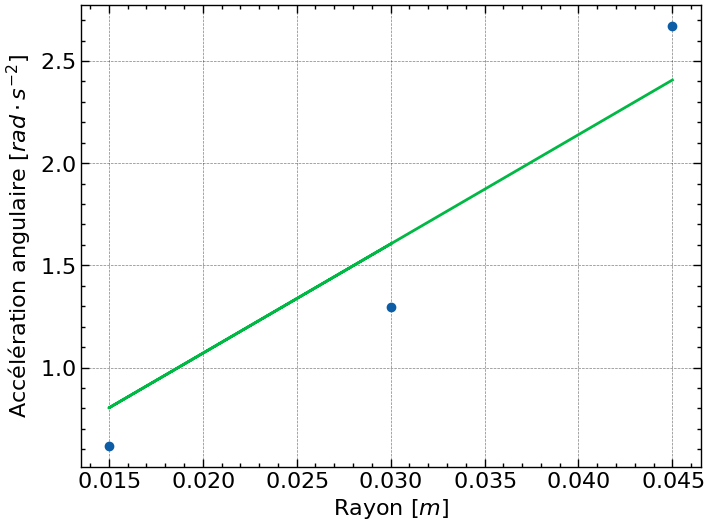

In [153]:
# Plot a graph of the acceleration against the radius for all the measure with mass 70g
plt.plot(tabular["Radius"][tabular["Mass"] == 70e-3], tabular["Angular Acceleration"][tabular["Mass"] == 70e-3], "o")
popt_fr, _ = sp.optimize.curve_fit(prop:=lambda x,a: a*x, tabular["Radius"][tabular["Mass"] == 70e-3], tabular["Angular Acceleration"][tabular["Mass"] == 70e-3])
plt.plot(np.array([r_m, r_p, r_g]), prop(np.array([r_m, r_p, r_g]), *popt_fr))
plt.xlabel(r"Rayon $[m]$")
plt.ylabel(r"Accélération angulaire $[rad \cdot s^{-2}]$")
plt.savefig("prop_rayon.png")

In [154]:
# average and std for the moment of inertia
I_mean = np.mean(tabular["Moment of Inertia"])
I_std = np.std(tabular["Moment of Inertia"])
print(I_mean, I_std)
rel = I_std/I_mean
print(f"Relative uncertainty: {rel*100}%")

0.015005949828400644 0.0016281219932735526
Relative uncertainty: 10.849842974898712%


In [155]:
tab_report = pd.DataFrame()
tab_report["M [kg]"] = tabular["Mass"].round(2)
tab_report["r [m]"] = tabular["Radius"].round(3)
tab_report["I [kg m2]"] = tabular["Moment of Inertia"].round(3)
tab_report["alpha [rad s-2]"] = tabular["Angular Acceleration"].round(3)
print(tab_report.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
 M [kg] &  r [m] &  I [kg m2] &  alpha [rad s-2] \\
\midrule
  0.040 &  0.030 &      0.015 &            0.791 \\
  0.060 &  0.030 &      0.016 &            1.133 \\
  0.070 &  0.015 &      0.017 &            0.618 \\
  0.070 &  0.030 &      0.016 &            1.297 \\
  0.070 &  0.045 &      0.012 &            2.673 \\
  0.080 &  0.030 &      0.016 &            1.435 \\
  0.100 &  0.030 &      0.014 &            2.092 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_25126/569439553.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab_report.to_latex(index=False, float_format="%.3f"))
